In [1]:
# Option Pricing with Stock Data Analysis

#This script analyzes stock data fetched via the Yahoo Finance API, calculates option prices using FFT, and visualizes results with detailed plots. The output is saved to a CSV file for further analysis.



### 1. Imports and Setup

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.fft import fft
from scipy.stats import norm
import pandas as pd

In [2]:
# Helper function to fetch stock data

def fetch_stock_data():
    stock_symbol = input("Enter the stock symbol (e.g., AAPL for Apple): ").strip()
    stock_data = yf.Ticker(stock_symbol)

    print(f"Fetching data for {stock_symbol}...")
    hist = stock_data.history(period="1y")
    if hist.empty:
        raise ValueError("Failed to fetch stock data. Please check the stock symbol.")

    print(f"Stock data fetched successfully!\n")
    return stock_symbol, hist

In [3]:
# user input for option expiry

def get_expiry():
    expiry = float(input("Enter the option expiry in years (e.g., 0.5 for 6 months): "))
    if expiry <= 0:
        raise ValueError("Expiry must be positive.")
    return expiry



def log_strike_partition(eta=0.25, N=4096):
    b = np.pi / eta
    lamb = 2 * np.pi / (eta * N)
    k = -b + lamb * np.arange(N)
    return b, lamb, k

In [4]:
#### FFT Pricing

def fft_price(S0, r, sigma, T, alpha=1.5, eta=0.25, N=4096):
    V = np.arange(0, N * eta, eta)
    b, lamb, k = log_strike_partition(eta, N)

    def modified_call_transform(v):
        denom = alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v
        phi = np.exp(1j * v * (np.log(S0) + (r - 0.5 * sigma**2) * T) - 0.5 * v**2 * sigma**2 * T)
        return np.exp(-r * T) * phi / denom

    Weights = eta / 3 * (3 + (-1)**np.arange(N))
    Weights[0] -= 1

    x = np.exp(1j * b * V) * modified_call_transform(V) * Weights
    call_prices = np.real(np.exp(-alpha * k) / np.pi * fft(x))

    return np.exp(k), call_prices

In [5]:
### 3. Analysis and Visualization
#### Perform Analysis

def perform_analysis(stock_data, stock_symbol, expiry):
    S0 = stock_data["Close"].iloc[-1]
    sigma = stock_data["Close"].pct_change().std() * np.sqrt(252)
    r = 0.03  # Assume a 3% annual risk-free rate

    print(f"Analyzing {stock_symbol}...\n")
    print(f"Current Stock Price: {S0:.2f}")
    print(f"Estimated Volatility: {sigma:.4f}")

    strikes, fft_prices = fft_price(S0, r, sigma, expiry)

    results = pd.DataFrame({
        "Strike Price": strikes,
        "Option Price": fft_prices
    })

    results.to_csv(f"{stock_symbol}_option_prices.csv", index=False)
    print(f"Results saved to {stock_symbol}_option_prices.csv\n")

    return strikes, fft_prices, S0, sigma


In [6]:
#### Visualize Results

def visualize_results(strikes, fft_prices, stock_symbol, S0, sigma):
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, fft_prices, label="Option Price via FFT", color="blue")
    plt.axvline(S0, color="red", linestyle="--", label=f"Current Price: {S0:.2f}")
    plt.title(f"Option Pricing Analysis for {stock_symbol}", fontsize=14)
    plt.xlabel("Strike Price", fontsize=12)
    plt.ylabel("Option Price", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

Fetching data for AAPL...
Stock data fetched successfully!

Analyzing AAPL...

Current Stock Price: 255.59
Estimated Volatility: 0.2267
Results saved to AAPL_option_prices.csv



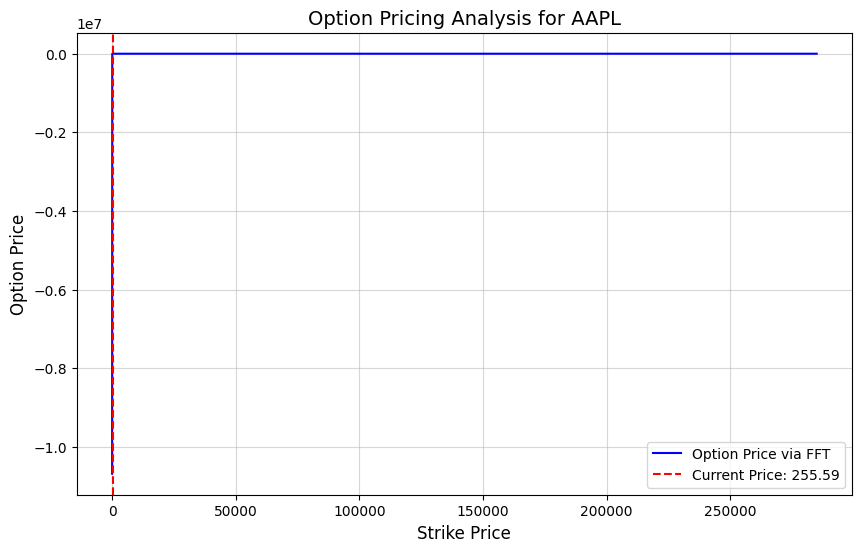

In [7]:
### 4. Main Function

def main():
    try:
        # Fetch stock data
        stock_symbol, stock_data = fetch_stock_data()

        # Get expiry
        expiry = get_expiry()

        # Perform analysis
        strikes, fft_prices, S0, sigma = perform_analysis(stock_data, stock_symbol, expiry)

        # Visualize results
        visualize_results(strikes, fft_prices, stock_symbol, S0, sigma)

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
